## use ccd_pkl env NOT boltz2 since it will break boltz

In [ ]:
# ! wget https://files.wwpdb.org/pub/pdb/data/monomers/components.cif

--2025-09-04 09:26:27--  https://files.wwpdb.org/pub/pdb/data/monomers/components.cif
Resolving files.wwpdb.org (files.wwpdb.org)... 108.156.91.23, 108.156.91.39, 108.156.91.31, ...
Connecting to files.wwpdb.org (files.wwpdb.org)|108.156.91.23|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 478965789 (457M) [chemical/x-cif]
Saving to: ‘components.cif.1’

components.cif.1    100%[===================>] 456.78M  71.5MB/s    in 6.6s    

2025-09-04 09:26:34 (69.2 MB/s) - ‘components.cif.1’ saved [478965789/478965789]



In [ ]:
# to get pkl file 
# this script workdir: /home/ymanasa/turbo/ymanasa/opt/boltz/covalent_testing/scripts/

#python ccd.py --components components.cif --outdir ./ccd


#### regular pkl from pdb archive

In [ ]:
import pickle
import elbow

pkl_7KH = '/home/ymanasa/.boltz/mols/7KH.pkl'
with open(pkl_7KH, 'rb') as file: 
    data = pickle.load(file)

type(data)

In [ ]:

smiles = "[H]/N=C/c1nc(nc(n1)N(Cc2cn3ccccc3n2)C4CCCC4)N5CCOCC5" # canonical SMILES openeye tools 7kh from PDB web
# smiles = "CC(C(C)(C)C)OP(=O)C" # GD8
# smiles = "CC(C)CC(C(=O)NC(CC1CCNC1=O)C(O)S(=O)(=O)O)NC(=O)OC(C)C2CCC(CC2)(F)F" # YKM



rdkit.Chem.rdchem.Mol

#### phenix elbow pickle

In [ ]:
phenix_pkl = '/home/ymanasa/turbo/ymanasa/opt/boltz/covalent_testing/mmcif_testing/7KH/7KH.pkl'
with open(phenix_pkl, 'rb') as file: 
    mol_loaded_orig = pickle.load(file)


ModuleNotFoundError: No module named 'elbow'

### getting pkl from rdkit with 3D conformers code from ccd.py boltz

In [1]:
import rdkit
from rdkit import Chem
from pdbeccdutils.core.component import ConformerType
def compute_3d(mol, version: str = "v3") -> bool:
    """Generate 3D coordinates using EKTDG method.

    Taken from `pdbeccdutils.core.component.Component`.

    Parameters
    ----------
    mol: Mol
        The RDKit molecule to process
    version: str, optional
        The ETKDG version, defaults ot v3
        

    Returns
    -------
    bool
        Whether computation was successful.

    """
    if version == "v3":
        options = rdkit.Chem.AllChem.ETKDGv3()
    elif version == "v2":
        options = rdkit.Chem.AllChem.ETKDGv2()
    else:
        options = rdkit.Chem.AllChem.ETKDGv2()

    options.clearConfs = False
    conf_id = -1

    try:
        conf_id = rdkit.Chem.AllChem.EmbedMolecule(mol, options)
        rdkit.Chem.AllChem.UFFOptimizeMolecule(mol, confId=conf_id, maxIters=1000)

    except RuntimeError:
        pass  # Force field issue here
    except ValueError:
        pass  # sanitization issue here

    if conf_id != -1:
        conformer = mol.GetConformer(conf_id)
        conformer.SetProp("name", ConformerType.Computed.name)
        conformer.SetProp("coord_generation", f"ETKDG{version}")
        
        return True

    return False


def get_conformer(mol, c_type: ConformerType):
    """Retrieve an rdkit object for a deemed conformer.

    Taken from `pdbeccdutils.core.component.Component`.

    Parameters
    ----------
    mol: Mol
        The molecule to process.
    c_type: ConformerType
        The conformer type to extract.

    Returns
    -------
    Conformer
        The desired conformer, if any.

    Raises
    ------
    ValueError
        If there are no conformers of the given tyoe.

    """
    for c in mol.GetConformers():
        try:
            if c.GetProp("name") == c_type.name:
                return c
        except KeyError:  # noqa: PERF203
            pass

    msg = f"Conformer {c_type.name} does not exist."
    raise ValueError(msg)

### smiles -> sdf -> rdkit mol has metadata needed?

In [ ]:
! pip install pybel 

In [ ]:
! pip install openbabel-wheel


In [1]:
import subprocess

smiles = "[H]/N=C/c1nc(nc(n1)N(Cc2cn3ccccc3n2)C4CCCC4)N5CCOCC5"
output_file = "7KH_noH.sdf"

cmd = [
    "obabel",
    f"-:{smiles}",
    "--gen3d",  # do not add hydrogens
    "-d", # delete Hs 
    "-O", output_file,  
    "--sd", # sdf format 
    "--v2000" # molfile version 2000  
]

subprocess.run(cmd, check=True)
print(f"SDF file written to {output_file}")

SDF file written to 7KH_noH.sdf


1 molecule converted


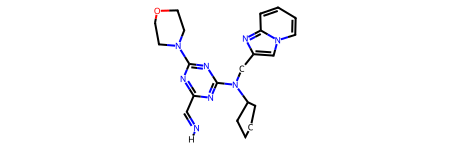

In [86]:
from rdkit import Chem
from rdkit.Chem import AllChem

# Load molecule
supplier = Chem.SDMolSupplier("7KH_rdkit.sdf")
mol_sdf = supplier[0]

# Add hydrogens
# mol = Chem.AddHs(mol) # dont add Hs bc original doesnt either 

# Generate 3D coordinates; not needed since --gen3d used in obabel
# params = AllChem.ETKDGv3()
# res = AllChem.EmbedMolecule(mol, params)

# Now mol is an RDKit Mol with 3D coordinates
# print(Chem.MolToMolBlock(mol_sdf))  # view MOL block with 3D coords
mol_sdf

In [87]:
# with rdkit does it work? yes but obabel is better for writing the sdf with 3D coords
smiles = "[H]/N=C/c1nc(nc(n1)N(Cc2cn3ccccc3n2)C4CCCC4)N5CCOCC5" 

mol2 = Chem.MolFromSmiles(smiles)
# mol2 = Chem.AddHs(mol2)

success = compute_3d(mol2, version="v3")
_ = get_conformer(mol2, ConformerType.Computed)

atom = mol2.GetAtomWithIdx(3)  # first atom

# Show all properties of the atom
print(atom.GetPropsAsDict())
print(dir(atom))
# i dont think it has all the same props/attributes as the one loaded from sdf

{'__computedProps': <rdkit.rdBase._vectNSt7__cxx1112basic_stringIcSt11char_traitsIcESaIcEEE object at 0x149cb2a5ef40>, '_CIPRank': 13}
['ClearProp', 'ClearPropertyCache', 'DescribeQuery', 'GetAtomMapNum', 'GetAtomicNum', 'GetBonds', 'GetBoolProp', 'GetChiralTag', 'GetDegree', 'GetDoubleProp', 'GetExplicitBitVectProp', 'GetExplicitValence', 'GetFormalCharge', 'GetHybridization', 'GetIdx', 'GetImplicitValence', 'GetIntProp', 'GetIsAromatic', 'GetIsotope', 'GetMass', 'GetMonomerInfo', 'GetNeighbors', 'GetNoImplicit', 'GetNumExplicitHs', 'GetNumImplicitHs', 'GetNumRadicalElectrons', 'GetOwningMol', 'GetPDBResidueInfo', 'GetProp', 'GetPropNames', 'GetPropsAsDict', 'GetQueryType', 'GetSmarts', 'GetSymbol', 'GetTotalDegree', 'GetTotalNumHs', 'GetTotalValence', 'GetUnsignedProp', 'GetValence', 'HasOwningMol', 'HasProp', 'HasQuery', 'HasValenceViolation', 'InvertChirality', 'IsInRing', 'IsInRingSize', 'Match', 'NeedsUpdatePropertyCache', 'SetAtomMapNum', 'SetAtomicNum', 'SetBoolProp', 'SetChira

[12:48:18] Molecule does not have explicit Hs. Consider calling AddHs()
[12:48:18] Molecule does not have explicit Hs. Consider calling AddHs()


In [52]:
sdf_writer = Chem.SDWriter("7KH_rdkit.sdf")
sdf_writer.write(mol2)
sdf_writer.close()

In [ ]:
mol = Chem.SDMolSupplier("7KH.sdf")[0]
mol_noHs = Chem.RemoveHs(mol)
type(mol_sdf)

rdkit.Chem.rdchem.Mol

### original pkl 

In [ ]:
import pickle
orig_pkl = '/home/ymanasa/.boltz/orig_mols/7KH.pkl'
with open(orig_pkl, 'rb') as file: 
    mol_loaded_orig = pickle.load(file)

In [ ]:
for i, atom in enumerate(mol_loaded_orig.GetAtoms()):
    print(atom.GetProp("name"))

In [24]:
# atom props
atom_orig = mol_loaded_orig.GetAtomWithIdx(0)  # first atom

# Show all properties of the atom
atom_origdict = atom_orig.GetPropsAsDict()
atom_origlist = dir(atom_orig)

In [25]:
atom_origdict

{'name': 'C5',
 'alt_name': 'C1',
 'leaving_atom': False,
 '_NonExplicit3DChirality': 1,
 '__computedProps': <rdkit.rdBase._vectNSt7__cxx1112basic_stringIcSt11char_traitsIcESaIcEEE at 0x153b78dcbdc0>,
 '_CIPRank': 7}

### diff between orig and sdf props for atoms

In [ ]:
list(set(atom_origdict) - set(atom_newdict)) # elements in orig but not in new
# not all atoms have these props

['alt_name', 'leaving_atom', 'name', '_NonExplicit3DChirality', '_CIPRank']

In [ ]:
list(set(atom_origlist) - set(atom_newlist))


[]

### diff between orig and sdf props for molecules

In [44]:
import pickle
phenix_pkl = '/home/ymanasa/.boltz/orig_mols/7KH.pkl'
with open(phenix_pkl, 'rb') as file: 
    mol_loaded_orig = pickle.load(file)

atom_orig_dict = mol_loaded_orig.GetPropsAsDict()
atom_orig_dict

{'MOL_NAME': '7KH',
 'symmetries': '800495080100000000000028284b004b014b024b034b044b054b064b074b084b094b0a4b0b4b0c4b0d4b0e4b0f4b104b114b124b134b144b154b164b174b184b194b1a4b1b4b1c4b1d4b1e7494284b004b014b024b0e4b044b054b0f4b074b084b094b0a4b0b4b0c4b0d4b034b064b104b114b124b134b144b154b164b174b184b194b1a4b1b4b1c4b1d4b1e7494284b024b014b004b034b044b074b064b054b084b094b0a4b0b4b0c4b0d4b0e4b0f4b104b114b124b134b144b154b164b174b184b194b1a4b1b4b1c4b1d4b1e7494284b024b014b004b0e4b044b074b0f4b054b084b094b0a4b0b4b0c4b0d4b034b064b104b114b124b134b144b154b164b174b184b194b1a4b1b4b1c4b1d4b1e749474942e',
 'pb_edge_index': '8004959f1d0000000000008c166e756d70792e5f636f72652e6d756c74696172726179948c0c5f7265636f6e7374727563749493948c056e756d7079948c076e6461727261799493944b0085944301629487945294284b014b024dd101869468038c0564747970659493948c02693894898887945294284b038c013c944e4e4e4affffffff4affffffff4b007494628942101d00000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000

In [55]:
from rdkit import Chem
from rdkit.Chem import AllChem

supplier = Chem.SDMolSupplier("7KH_rdkit.sdf")
mol = supplier[0]
# mol = Chem.AddHs(mol)
# params = AllChem.ETKDGv3()
# res = AllChem.EmbedMolecule(mol, params)

atom_sdf_dict = mol.GetPropsAsDict()

In [58]:
list(set(atom_orig_dict) - set(atom_sdf_dict))

['stereo_bond_orientations',
 'pb_lower_bounds',
 'aromatic_6_ring_index',
 'pb_edge_index',
 'chiral_check_mask',
 'aromatic_5_ring_index',
 'symmetries',
 'pb_angle_mask',
 'stereo_check_mask',
 'pb_bond_mask',
 'chiral_atom_orientations',
 'MOL_NAME',
 'chiral_atom_index',
 'pb_upper_bounds',
 'planar_double_bond_index',
 'stereo_bond_index']

### how to get the missing props for atoms? 

#### _CIFRank

In [ ]:
from rdkit import Chem
from rdkit.Chem import AllChem

# _CIPRank is rank following Cahn-Ingold-Prelog rules for stereochemistry (R/S for chiral centers)
# loading rdkit made sdf 
supplier = Chem.SDMolSupplier("7KH.sdf")
mol_sdf = supplier[0]

# # assign sterochemistry
# Chem.AssignStereochemistry(mol2, cleanIt=True, force=True, flagPossibleStereoCenters=True)

atom_sdf = mol2.GetAtomWithIdx(10)
atom_sdf_dict = atom_sdf.GetPropsAsDict()
atom_sdf_dict
# CIPRank 12 is not weird (doesnt need to be from 0-3) bc its relative global ranking of all stereocenters in the molecule
# only whether atom A has a lower rank than atom B matters for determining R/S



{'__computedProps': <rdkit.rdBase._vectNSt7__cxx1112basic_stringIcSt11char_traitsIcESaIcEEE at 0x149cb2a5efc0>,
 '_CIPRank': 6}

In [ ]:
for atom in mol_loaded_orig.GetAtoms():
    # props = atom.GetPropsAsDict(includePrivate=True, includeComputed=True)
    # print(atom.GetIdx(), atom.GetSymbol(), props)
    print(atom.GetFormalCharge())

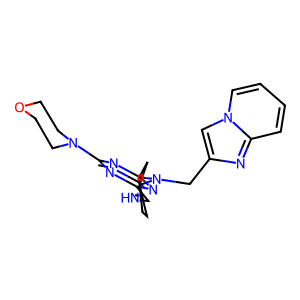

In [81]:
from rdkit.Chem import Draw

Draw.MolToImage(mol_sdf, size=(300,300))

In [61]:
import pickle
phenix_pkl = '/home/ymanasa/.boltz/orig_mols/7KH.pkl'
with open(phenix_pkl, 'rb') as file: 
    mol_loaded_orig = pickle.load(file)

# atom props
atom_orig = mol_loaded_orig.GetAtomWithIdx(25)  # first atom

# Show all properties of the atom
atom_origdict = atom_orig.GetPropsAsDict()
atom_origdict
    

{'name': 'C26',
 'alt_name': 'C17',
 'leaving_atom': False,
 '__computedProps': <rdkit.rdBase._vectNSt7__cxx1112basic_stringIcSt11char_traitsIcESaIcEEE at 0x149cb2a5cbc0>,
 '_CIPRank': 10}

In [92]:
for atom in mol_loaded_orig.GetAtoms():
    props = atom.GetPropsAsDict(includePrivate=True, includeComputed=True)
    print(atom.GetIdx(), atom.GetSymbol(), props)

0 C {'name': 'C5', 'alt_name': 'C1', 'leaving_atom': False, '_NonExplicit3DChirality': 1, '__computedProps': <rdkit.rdBase._vectNSt7__cxx1112basic_stringIcSt11char_traitsIcESaIcEEE object at 0x149cb2a5cc40>, '_CIPRank': 7}
1 C {'name': 'C8', 'alt_name': 'C2', 'leaving_atom': False, '__computedProps': <rdkit.rdBase._vectNSt7__cxx1112basic_stringIcSt11char_traitsIcESaIcEEE object at 0x149cb2a5d5c0>, '_CIPRank': 12}
2 C {'name': 'C1', 'alt_name': 'C3', 'leaving_atom': False, '_NonExplicit3DChirality': 1, '__computedProps': <rdkit.rdBase._vectNSt7__cxx1112basic_stringIcSt11char_traitsIcESaIcEEE object at 0x149cb2a5fa40>, '_CIPRank': 7}
3 C {'name': 'C14', 'alt_name': 'C4', 'leaving_atom': False, '_NonExplicit3DChirality': 1, '__computedProps': <rdkit.rdBase._vectNSt7__cxx1112basic_stringIcSt11char_traitsIcESaIcEEE object at 0x149cb2a5cc40>, '_CIPRank': 2}
4 C {'name': 'C9', 'alt_name': 'C5', 'leaving_atom': False, '__computedProps': <rdkit.rdBase._vectNSt7__cxx1112basic_stringIcSt11char_tr

#### _NonExplicit3DChirality

In [93]:
from rdkit import Chem
from rdkit.Chem import AllChem

supplier = Chem.SDMolSupplier("7KH_rdkit.sdf")
mol_sdf = supplier[0]

Chem.AssignAtomChiralTagsFromStructure(mol2)

for atom in mol2.GetAtoms():
    if atom.HasProp('_NonExplicit3DChirality'):
        print(atom.GetSymbol(), atom.GetProp('_NonExplicit3DChirality'))
        print(atom.GetPropsAsDict())



C 1
{'__computedProps': <rdkit.rdBase._vectNSt7__cxx1112basic_stringIcSt11char_traitsIcESaIcEEE object at 0x149cb2a5f4c0>, '_CIPRank': 8, '_NonExplicit3DChirality': 1}


In [96]:
import pickle
phenix_pkl = '/home/ymanasa/.boltz/orig_mols/7KH.pkl'
with open(phenix_pkl, 'rb') as file: 
    mol_loaded_orig = pickle.load(file)

for atom in mol_loaded_orig.GetAtoms():
    if atom.HasProp('_NonExplicit3DChirality'):
        print(atom.GetSymbol(), atom.GetIdx(), atom.GetProp('_NonExplicit3DChirality'))
    

C 0 1
C 2 1
C 3 1
C 5 1
C 6 1
C 7 1
C 13 1
C 14 1
C 15 1
C 16 1


In [28]:
for atom in mol_loaded_orig.GetAtoms():
    props = atom.GetPropsAsDict(includePrivate=True, includeComputed=True)
    if props:  # empty dict
        print(f"Atom {atom.GetIdx()} ({atom.GetSymbol()}) has empty dict")


Atom 0 (C) has empty dict
Atom 1 (C) has empty dict
Atom 2 (C) has empty dict
Atom 3 (C) has empty dict
Atom 4 (C) has empty dict
Atom 5 (C) has empty dict
Atom 6 (C) has empty dict
Atom 7 (C) has empty dict
Atom 8 (C) has empty dict
Atom 9 (N) has empty dict
Atom 10 (O) has empty dict
Atom 11 (N) has empty dict
Atom 12 (N) has empty dict
Atom 13 (C) has empty dict
Atom 14 (C) has empty dict
Atom 15 (C) has empty dict
Atom 16 (C) has empty dict
Atom 17 (N) has empty dict
Atom 18 (N) has empty dict
Atom 19 (C) has empty dict
Atom 20 (N) has empty dict
Atom 21 (C) has empty dict
Atom 22 (N) has empty dict
Atom 23 (C) has empty dict
Atom 24 (N) has empty dict
Atom 25 (C) has empty dict
Atom 26 (C) has empty dict
Atom 27 (C) has empty dict
Atom 28 (C) has empty dict
Atom 29 (C) has empty dict
Atom 30 (H) has empty dict


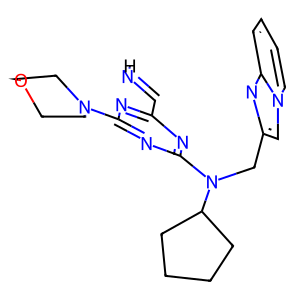

In [70]:
from rdkit.Chem import Draw

Draw.MolToImage(mol_loaded_orig, size=(300,300))

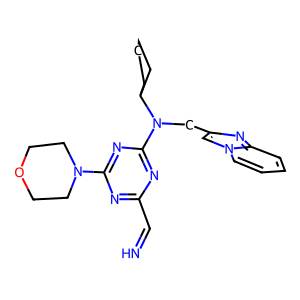

In [45]:
from rdkit.Chem import Draw

Draw.MolToImage(mol_sdf, size=(300,300))

In [24]:
mol_sdf.GetNumAtoms(), mol_loaded_orig.GetNumAtoms()

(56, 31)

#### alt_name, leaving_atom, name

In [ ]:
for i, atom in enumerate(mol_sdf.GetAtoms()):
    print(atom.GetProp("name"), atom.GetSymbol()+ str(atom.GetIdx()))

atom.SetProp("alt_name", atom.GetSymbol()+ str(atom.GetIdx()))


#### need to work getprop(name), getatomic number, get formal charge


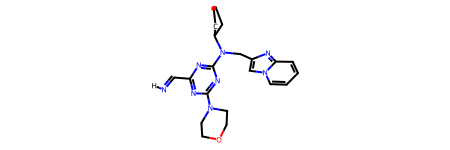

In [29]:
import rdkit
from rdkit import Chem

supplier = Chem.SDMolSupplier("7KH_edited.sdf") # this is a combo of obabel and rdkit generated sdf
mol_sdf = supplier[0]

mol_sdf

In [ ]:
for i, atom in enumerate(mol_sdf.GetAtoms()):
    print(atom.GetProp("name"), atom.GetSymbol()+ str(atom.GetIdx()))

#### adding name props


In [30]:
for i, atom in enumerate(mol_sdf.GetAtoms()):
    atom_id = atom.GetSymbol()+ str(atom.GetIdx())
    atom.SetProp("name", atom_id)

In [ ]:
for i, atom in enumerate(mol_sdf.GetAtoms()):
    print(atom.GetProp("name"))

In [32]:
import pickle
orig_pkl = '7KH.pkl'
with open(orig_pkl, 'rb') as file: 
    mol_orig = pickle.load(file)

mol_orig.GetNumAtoms()

31

#### get the pkl from the sdf 

In [33]:
Chem.SetDefaultPickleProperties(Chem.PropertyPickleOptions.AllProps)
with open("7KH.pkl", "wb") as f:
    pickle.dump(mol_sdf, f)

In [ ]:
with open("7KH.pkl", "rb") as f:
    mol_loaded = pickle.load(f)

for atom in mol_loaded.GetAtoms():
    print(atom.GetProp("name"))

### trying with rdkit sdf 

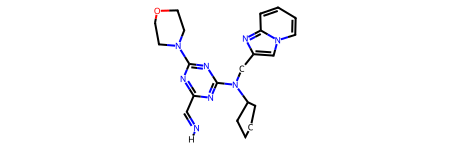

In [19]:
import rdkit
from rdkit import Chem

supplier = Chem.SDMolSupplier("7KH_rdkit.sdf") # this is a combo of obabel and rdkit generated sdf
mol_sdf = supplier[0]

mol_sdf

In [20]:
for i, atom in enumerate(mol_sdf.GetAtoms()):
    atom_id = atom.GetSymbol()+ str(atom.GetIdx())
    atom.SetProp("name", atom_id)

In [21]:
Chem.SetDefaultPickleProperties(Chem.PropertyPickleOptions.AllProps)
with open("7KH.pkl", "wb") as f:
    pickle.dump(mol_sdf, f)

In [22]:
! cp 7KH.pkl /home/ymanasa/.boltz/mols/

In [ ]:
with open("/home/ymanasa/.boltz/mols/7KH.pkl", "rb") as f:
    mol_loaded = pickle.load(f)

for atom in mol_loaded.GetAtoms():
    print(atom.GetChiralTag())

# Final

In [ ]:
# 7KH conanical smiles from RCSBPDB 5MAJ
smiles = "[H]/N=C/c1nc(nc(n1)N(Cc2cn3ccccc3n2)C4CCCC4)N5CCOCC5" 

mol2 = Chem.MolFromSmiles(smiles) # dont add Hs bc original noncov code does but removes conformer gen 

success = compute_3d(mol2, version="v3")
_ = get_conformer(mol2, ConformerType.Computed)

sdf_writer = Chem.SDWriter("7KH_rdkit2.sdf")
sdf_writer.write(mol2)
sdf_writer.close()

for i, atom in enumerate(mol_sdf.GetAtoms()):
    atom_id = atom.GetSymbol()+ str(atom.GetIdx())
    atom.SetProp("name", atom_id)

Chem.SetDefaultPickleProperties(Chem.PropertyPickleOptions.AllProps)
with open("7KH.pkl", "wb") as f:
    pickle.dump(mol_sdf, f)

[14:34:08] Molecule does not have explicit Hs. Consider calling AddHs()
[14:34:08] Molecule does not have explicit Hs. Consider calling AddHs()


In [13]:
# BKM conanical smiles from RCSBPDB 6ALZ 
smiles = r"CCC(\C=C)=C/C(=O)C[C@H](C)C[C@@H](C)CC[C@H](O)[C@H](C)C(=O)C[C@@H](O)[C@H](C)[C@@H](C)OC(=O)C[C@@H](O)\C(C(O)=O)=C(/C)C(O)=O"
# r added to escape backslashes 

mol_sdf = Chem.MolFromSmiles(smiles) # dont add Hs bc original noncov code does but removes conformer gen 

success = compute_3d(mol_sdf, version="v3")
_ = get_conformer(mol_sdf, ConformerType.Computed)

sdf_writer = Chem.SDWriter("../mmcif_testing/6ALZ_rdkit/6ALZ_rdkit.sdf")
sdf_writer.write(mol_sdf)
sdf_writer.close()

for i, atom in enumerate(mol_sdf.GetAtoms()):
    atom_id = atom.GetSymbol()+ str(atom.GetIdx())
    atom.SetProp("name", atom_id)

Chem.SetDefaultPickleProperties(Chem.PropertyPickleOptions.AllProps)
with open("../mmcif_testing/6ALZ_rdkit/BKM.pkl", "wb") as f:
    pickle.dump(mol_sdf, f)

[06:39:04] Molecule does not have explicit Hs. Consider calling AddHs()
[06:39:05] Molecule does not have explicit Hs. Consider calling AddHs()


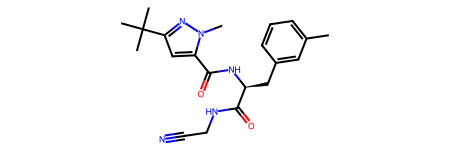

In [19]:
smiles = r"O=C(N[C@@H](CC1=CC(C)=CC=C1)C(NCC#N)=O)C2=CC(C(C)(C)C)=NN2C" # NAD-1-34 molecule in Master SAR table 09.01.2022

mol_sdf = Chem.MolFromSmiles(smiles) # dont add Hs bc original noncov code does but removes conformer gen 

mol_sdf

In [ ]:
success = compute_3d(mol_sdf, version="v3")
_ = get_conformer(mol_sdf, ConformerType.Computed)

# sdf_writer = Chem.SDWriter("../mmcif_testing/5MAJ/NAD-1-34/NAD-1-34.sdf")
# sdf_writer.write(mol_sdf)
# sdf_writer.close()

for i, atom in enumerate(mol_sdf.GetAtoms()):
    atom_id = atom.GetSymbol()+ str(atom.GetIdx())
    atom.SetProp("name", atom_id)

Chem.SetDefaultPickleProperties(Chem.PropertyPickleOptions.AllProps)
with open("../mmcif_testing/5MAJ/NAD-1-34/NAD.pkl", "wb") as f:
    pickle.dump(mol_sdf, f)

[07:34:21] Molecule does not have explicit Hs. Consider calling AddHs()
[07:34:21] Molecule does not have explicit Hs. Consider calling AddHs()


## symmetry

In [ ]:
import argparse
import multiprocessing
import pickle
import sys
from functools import partial
from pathlib import Path

import pandas as pd
import rdkit
from p_tqdm import p_uimap
from pdbeccdutils.core import ccd_reader
from pdbeccdutils.core.component import ConformerType
from rdkit import rdBase
from rdkit.Chem import AllChem
from rdkit.Chem.rdchem import Conformer, Mol
from tqdm import tqdm

def compute_symmetries(mol) -> list[list[int]]:
    """Compute the symmetries of a molecule.

    Parameters
    ----------
    mol : Mol
        The molecule to process

    Returns
    -------
    list[list[int]]
        The symmetries as a list of index permutations

    """
    mol = AllChem.RemoveHs(mol)
    idx_map = {}
    atom_idx = 0
    for i, atom in enumerate(mol.GetAtoms()):
        # Skip if leaving atoms
        if int(atom.GetProp("leaving_atom")):
            continue
        idx_map[i] = atom_idx
        atom_idx += 1

    # Calculate self permutations
    permutations = []
    raw_permutations = mol.GetSubstructMatches(mol, uniquify=False)
    for raw_permutation in raw_permutations:
        # Filter out permutations with leaving atoms
        try:
            if {raw_permutation[idx] for idx in idx_map} == set(idx_map.keys()):
                permutation = [
                    idx_map[idx] for idx in raw_permutation if idx in idx_map
                ]
                permutations.append(permutation)
        except Exception:  # noqa: S110, PERF203, BLE001
            pass
    serialized_permutations = pickle.dumps(permutations)
    print(serialized_permutations)
    mol.SetProp("symmetries", serialized_permutations.hex())
    return permutations

In [54]:
import pickle
pkl = '/home/ymanasa/.boltz/orig_mols/7KH.pkl'
with open(pkl, 'rb') as file: 
    mol_7kh = pickle.load(file)

# for atom in mol_7kh.GetAtoms():
#     if atom.GetSymbol() == "H":
#         atom.SetProp("leaving_atom", "1")
#         print('set')
        
#     else: 
#         atom.SetProp("leaving_atom", "0")
for i, atom in enumerate(mol_7kh.GetAtoms()):

        if atom.GetSymbol() == "H":
            print('found leaving atom')
            print(atom.GetSymbol(), atom.GetIdx())




found leaving atom
H 30


In [ ]:
for i, atom in enumerate(mol_7kh.GetAtoms()):
        # Skip if leaving atoms
        print(atom.GetProp("leaving_atom"))

In [ ]:
compute_symmetries(mol_7kh)

In [ ]:
mol_7kh.GetPropsAsDict()

AttributeError: 'Mol' object has no attribute 'GetPropsAsList'

## leaving atom 

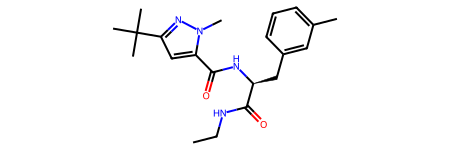

In [55]:
# just delete it from the smiles 
smiles = r"O=C(N[C@@H](CC1=CC(C)=CC=C1)C(NCC)=O)C2=CC(C(C)(C)C)=NN2C" # NAD-1-34 molecule in Master SAR table 09.01.2022

mol_sdf = Chem.MolFromSmiles(smiles) 
mol_sdf


In [57]:
success = compute_3d(mol_sdf, version="v3")
_ = get_conformer(mol_sdf, ConformerType.Computed)

for i, atom in enumerate(mol_sdf.GetAtoms()):
    atom_id = atom.GetSymbol()+ str(atom.GetIdx())
    atom.SetProp("name", atom_id)

Chem.SetDefaultPickleProperties(Chem.PropertyPickleOptions.AllProps)
with open("../mmcif_testing/5MAJ/NAD-1-34/noleaving_atom_smi/NA2.pkl", "wb") as f:
    pickle.dump(mol_sdf, f)

[11:30:46] Molecule does not have explicit Hs. Consider calling AddHs()
[11:30:46] Molecule does not have explicit Hs. Consider calling AddHs()


In [2]:
import os, string, sys
from openeye.oechem import *

def remove_cyano_from_smiles(smiles: str) -> list[str]:
    """
    Removes nitrile leaving groups (-C≡N) from a SMILES string.
    
    Parameters
    ----------
    smiles : str
        Input SMILES string.
    
    Returns
    -------
    list[str]
        List of SMILES strings for the products (may be multiple if multiple matches).
    """
    mol = OEGraphMol()
    if not OEParseSmiles(mol, smiles):
        raise ValueError(f"Invalid SMILES: {smiles}")

    # Reaction: break C≡N, drop the nitrogen
    reaction = "[C:1]#[N:2]>>[C:1]"

    libgen = OELibraryGen(reaction)
    libgen.SetExplicitHydrogens(False)
    libgen.SetValenceCorrection(False)

    libgen.Init()
    libgen.AddStartingMaterial(mol, 0)

    products = []
    for product in libgen.GetProducts():
        smi = OECreateIsoSmiString(product)
        products.append(smi)

    return products


smiles = r"O=C(N[C@@H](CC1=CC(C)=CC=C1)C(NCC#N)=O)C2=CC(C(C)(C)C)=NN2C" # NAD-1-34 molecule in Master SAR table 09.01.2022

In [ ]:
remove_cyano_from_smiles(smiles)

: 

In [8]:
from rdkit import Chem
from rdkit.Chem import AllChem

def remove_cyano_rdkit(smiles: str) -> list[str]:
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        raise ValueError(f"Invalid SMILES: {smiles}")

    rxn = AllChem.ReactionFromSmarts("[C:1]#[N:2]>>[C:1]")
    products = rxn.RunReactants((mol,))

    out = []
    for prod_tuple in products:
        for prod in prod_tuple:
            smi = Chem.MolToSmiles(prod)
            out.append(smi)
    return out

In [18]:
smiles = r"O=C(N[C@@H](CC1=CC(C)=CC=C1)C(NCC=N)=O)C2=CC(C(C)(C)C)=NN2C" 
# smiles_after = remove_cyano_rdkit(smiles)[0]

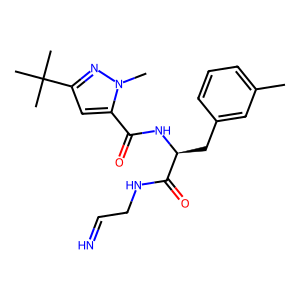

In [19]:
from rdkit.Chem import Draw
mol = Chem.MolFromSmiles(smiles)
Draw.MolToImage(mol, size=(300,300))

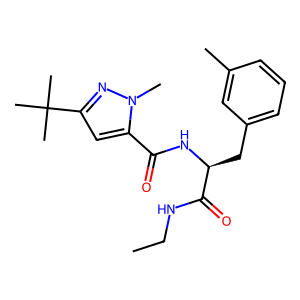

In [16]:
from rdkit.Chem import Draw

mol = Chem.MolFromSmiles(smiles_after)
Draw.MolToImage(mol, size=(300,300))

In [3]:
import pickle

smiles = r"O=C(N[C@@H](CC1=CC(C)=CC=C1)C(NCC#N)=O)C2=CC(C(C)(C)C)=NN2C" # NAD-1-34 molecule in Master SAR table 09.01.2022

mol_sdf = Chem.MolFromSmiles(smiles) # dont add Hs bc original noncov code does but removes conformer gen 

success = compute_3d(mol_sdf, version="v3")
_ = get_conformer(mol_sdf, ConformerType.Computed)

for i, atom in enumerate(mol_sdf.GetAtoms()):
    atom_id = atom.GetSymbol()+ str(atom.GetIdx())
    atom.SetProp("name", atom_id)

Chem.SetDefaultPickleProperties(Chem.PropertyPickleOptions.AllProps)
with open("../mmcif_testing/5MAJ/NAD-1-34/NA3.pkl", "wb") as f:
    pickle.dump(mol_sdf, f)

[10:39:14] Molecule does not have explicit Hs. Consider calling AddHs()
[10:39:14] Molecule does not have explicit Hs. Consider calling AddHs()


# clean functions
## in ccd_pkl

In [2]:
import os
import csv
import sys
import subprocess
# from fasta_utils import build_fasta_seq
# from mmseqs2 import run_mmseqs2
import argparse
# from covalent_utils import process_cov_smiles, get_prot_atom, identify_lg
from rdkit import Chem
from rdkit.Chem import AllChem


In [3]:
def check_smiles(smiles: str, verbose: bool = False):
    """
    Attempts to load and sanitize a SMILES string using RDKit.
    Returns a canonicalized SMILES string if successful, otherwise None.
    
    Parameters:
    - smiles (str): The input SMILES string.
    - verbose (bool): If True, print debug messages on failure.

    Returns:
    - str or None: A valid, canonical SMILES or None if the molecule is invalid.
    """
    try:
        # Attempt to parse without sanitizing
        mol = Chem.MolFromSmiles(smiles, sanitize=False)
        if mol is None:
            if verbose:
                print(f"[ERROR] MolFromSmiles failed for: {smiles}")
            return None
        
        # Attempt sanitization (includes valence check, aromaticity, Hs)
        Chem.SanitizeMol(mol)

        # Return the canonical SMILES
        return Chem.MolToSmiles(mol, canonical=True)

    except Exception as e:
        if verbose:
            print(f"[ERROR] Sanitization failed for SMILES: {smiles}\n{e}")
        return None

In [4]:
smiles = r"O=C(N[C@@H](CC1=CC(C)=CC=C1)C(NCC#N)=O)C2=CC(C(C)(C)C)=NN2C"
check_smiles(smiles)

'Cc1cccc(C[C@H](NC(=O)c2cc(C(C)(C)C)nn2C)C(=O)NCC#N)c1'

In [5]:
from covalent_utils import process_covalent_smiles
process_covalent_smiles(smiles, ccd_db="/home/ymanasa/turbo/ymanasa/opt/maom_boltz/scripts/")

[09:20:06] Molecule does not have explicit Hs. Consider calling AddHs()
[09:20:06] Molecule does not have explicit Hs. Consider calling AddHs()


'PYVOC'

In [5]:
def remove_lg(smiles, warhead_type, smarts_rxns="SMARTS.csv"):  

    mol = Chem.MolFromSmiles(smiles)
    with open(smarts_rxns, 'r') as file:
        reader = csv.DictReader(file)
        for row in reader:
            if warhead_type == row["warhead_type"]:
                rxn = AllChem.ReactionFromSmarts(row["SMARTS"])
                try:
                    products = rxn.RunReactants((mol,))

                    for prod_tuple in products:
                        for prod in prod_tuple:
                            smi_no_lg = Chem.MolToSmiles(prod)
                     
                    return smi_no_lg
                except: 
                    raise ValueError("Reaction could not be applied to the given SMILES.")


In [7]:
smiles = "O=C(N[C@@H](CC1=CC(C)=CC=C1)C(NCC#N)=O)C2=CC(C(C)(C)C)=NN2C"
s = remove_lg(smiles, warhead_type="nitrile")
print(s)


Cc1cccc(C[C@H](NC(=O)c2cc(C(C)(C)C)nn2C)C(=O)NC[13CH]=N)c1


In [41]:
char_indices = [i for i, c in enumerate(smiles) if c.isalnum() or c == '*']
star_pos = char_indices.index(next(i for i in char_indices if smiles[i] == '*'))
print(star_pos)

18


## TESTING

testing with these ligands and docking to HsCPL (5MAJ) and TgCPL (3F75):

7KH = `N#Cc1nc(nc(n1)N(Cc2cn3ccccc3n2)C4CCCC4)N5CCOCC5`

NAD-1-34 = `O=C(N[C@@H](CC1=CC(C)=CC=C1)C(NCC#N)=O)C2=CC(C(C)(C)C)=NN2C`

NAD-1-33 = `O=C(N[C@@H](CC1=CC(C)=CC=C1)C(NCC#N)=O)C2=CC(C(F)(F)F)=CC=C2`

NAD-1-52 = `O=C(N[C@@H](CC1=CC(C)=CC=C1)C(NCC#N)=O)C2=CC(C(C)(C)C)=CC=C2`


In [2]:
import make_input_csv

# 5MAJ
make_input_csv.generate_csv(prot_file='test/5MAJ.pdb', res_idx=25, lig_csv='test/test_ligs.csv', out_csv='test/test_out.csv')



TypeError: unhashable type: 'list'

In [32]:
from rdkit import Chem
from rdkit.Chem import AllChem

WARHEAD_REACTIONS = { "nitrile": "[C:3][C:4]#[N:5]>>[C:3][13C:4]=[N:5]", 
"alkylhalide" : "[CX4;CH,CH2:2][I,Br,Cl:3]>>[13C:2]",
"vinyl-sulfone" : "[C:3]=[C:4][S:5](=O)=O>>[13C:3][C:4][S:5](=O)=O", # for CYS rxn; might be diff for HIS (Schneider, Grabowsky 2015)
"acrylamide" : "[C:2]=[C:3]-C(=O)-[N:4]>>[13C:3]-[C:2]-C(=O)-[N:4]",
"nitrile2": "[N:4]#[C:5]>>[N:4]=[13C:5]"
}
WARHEAD_REACTANTS = {name: smarts.split(">>")[0] for name, smarts in WARHEAD_REACTIONS.items()}
compiled_reactants = {name: Chem.MolFromSmarts(smarts) for name, smarts in WARHEAD_REACTANTS.items()}

In [59]:
smiles = 'O=C(N[C@@H](CC1=CC(C)=CC=C1)C(NCC#N)=O)C2=CC(C(C)(C)C)=NN2C'

In [60]:
def identify_warhead(smiles):
    """
    Identifies and returns the names of covalent warheads found in a given molecule.
    
    :param smiles (str): The SMILES representation of the molecule.
        
    :returns (list): A list of warhead names found in the molecule.
    """

    mol = Chem.MolFromSmiles(smiles)
    if not mol:
        print("Invalid SMILES string.")
        return []
        
    found_warheads = []
    for name, pattern in compiled_reactants.items():
        if pattern and mol.HasSubstructMatch(pattern):
            found_warheads.append(name)

    if len(found_warheads) > 1:
        print("More than 1 warhead found. Choosing first match.")
    elif len(found_warheads) == 0:
        raise ValueError('No matching warhead was found.')
        
    return found_warheads[0]

identify_warhead(smiles)


More than 1 warhead found. Choosing first match.


'nitrile'

In [61]:
def ligand_cov_atom(no_lg_smiles):
    """
    Finds the index of the first Carbon-13 ([13C]) atom in a SMILES string.

    Args:
        smiles_string (str): The SMILES string to parse.

    Returns:
        int: The 0-based index of the first C13 atom found.
             Returns -1 if no C13 atom is found or the SMILES is invalid.
    """
    mol = Chem.MolFromSmiles(no_lg_smiles)

    if not mol:
        print("Error: Invalid SMILES string provided.")
        return -1

    for atom in mol.GetAtoms():
        if atom.GetSymbol() == 'C' and atom.GetIsotope() == 13:
            return f'C{atom.GetIdx()}'

    return -1

# no_lg = 'Cc1cccc(C[C@H](NC(=O)c2cc(C(C)(C)C)nn2C)C(=O)NC[13CH]=N)c1'
# ligand_cov_atom('N=[13CH]c1nc(N2CCOCC2)nc(N(Cc2cn3ccccc3n2)C2CCCC2)n1')


In [74]:
def remove_leaving_group(smiles):
    mol = Chem.MolFromSmiles(smiles)
    wh_type = identify_warhead(smiles)

    rxn = AllChem.ReactionFromSmarts(WARHEAD_REACTIONS[wh_type])

    products = rxn.RunReactants((mol,))

    for prod_tuple in products: # returns ((<rdkit.Chem.rdchem.Mol object at 0x14d267c24040>,),) 
        for prod in prod_tuple:
            smi_no_lg = Chem.MolToSmiles(prod)

    lig_atom = ligand_cov_atom(smi_no_lg)
    print(smi_no_lg)
    smi_no_c13 = smi_no_lg.replace("13", "")

    return smi_no_c13, lig_atom, wh_type

smi_no_c13, lig_atom, wh_type = remove_leaving_group(smiles)

More than 1 warhead found. Choosing first match.
Cc1cccc(C[C@H](NC(=O)c2cc(C(C)(C)C)nn2C)C(=O)NC[13CH]=N)c1


In [72]:
lig_atom

'C25'

In [70]:
import rdkit
import os
import pickle
import string
import random
from pdbeccdutils.core.component import ConformerType

def unique_ccd(length=5, max_attempts=10, ccd_db="/home/ymanasa/.bolts/mols"):
    '''Generates a unique alphanumeric string of specified length and ensures uniqueness.'''
    chars = string.ascii_uppercase + string.digits

    for _ in range(max_attempts):
        ccd = ''.join(random.choices(chars, k=length))
        if not os.path.exists(f"{ccd_db}/{ccd}.pkl"):
            return ccd
    raise RuntimeError("Could not find an available CCD after max attempts.")

def process_covalent_smiles(smiles, ccd_db="/home/ymanasa/.boltz/mols"):
    '''
    Creates a covalent CCD ligand from a conanical SMILES string using Rdkit.
    :param smiles (str): Sanitized canonical SMILES string of the covalent ligand.
    :param ccd_db (str): Path to the CCD database directory where .pkl files are stored.
    :return (str): Unique CCD code for the covalent ligand.
    '''
    mol_sdf = Chem.MolFromSmiles(smiles) 

    success = compute_3d(mol_sdf)
    if not success:
        raise ValueError("3D coordinate generation failed for the provided SMILES.")
    _ = get_conformer(mol_sdf, ConformerType.Computed)

    for i, atom in enumerate(mol_sdf.GetAtoms()):
        atom_id = atom.GetSymbol()+ str(atom.GetIdx())
        atom.SetProp("name", atom_id)
    
    Chem.SetDefaultPickleProperties(Chem.PropertyPickleOptions.AllProps)
    ccd = unique_ccd(ccd_db=ccd_db)
    with open(f"{ccd_db}/{ccd}.pkl", "wb") as f:
        pickle.dump(mol_sdf, f)
    return ccd

def compute_3d(mol) -> bool:
    '''Generate 3D coordinates using EKTDG method.
    Taken from `pdbeccdutils.core.component.Component`.
    :param mol: Mol
        The RDKit molecule to process
    :return: bool 
        Whether computation was successful.
    '''
    options = rdkit.Chem.AllChem.ETKDGv3()
    options.clearConfs = False
    conf_id = -1

    try:
        conf_id = rdkit.Chem.AllChem.EmbedMolecule(mol, options)
        rdkit.Chem.AllChem.UFFOptimizeMolecule(mol, confId=conf_id, maxIters=1000)

    except RuntimeError:
        pass  # Force field issue here
    except ValueError:
        pass  # sanitization issue here

    if conf_id != -1:
        conformer = mol.GetConformer(conf_id)
        conformer.SetProp("name", ConformerType.Computed.name)
        conformer.SetProp("coord_generation", f"ETKDGv3")
        
        return True
    return False

def get_conformer(mol, c_type: ConformerType):
    ''' 
    Retrieve an rdkit object for a deemed conformer.
    Taken from `pdbeccdutils.core.component.Component`.
    :param mol: Mol
        The molecule to process.
    :param c_type: ConformerType
        The conformer type to extract.
    :return: Conformer
        The desired conformer, if any.
    '''
    for c in mol.GetConformers():
        try:
            if c.GetProp("name") == c_type.name:
                return c
        except KeyError:  # noqa: PERF203
            pass

    msg = f"Conformer {c_type.name} does not exist."
    raise ValueError(msg)

In [71]:
process_covalent_smiles(smi_no_c13)

[10:31:11] Molecule does not have explicit Hs. Consider calling AddHs()
[10:31:11] Molecule does not have explicit Hs. Consider calling AddHs()


'IM1WU'

### Final testing of big scripts
1. preprocessing/make_input_csv.py
2. setup_cov_jobs.py
3. submit_jobs.py 


In [1]:
import make_input_csv
make_input_csv.generate_csv(name='5MAJ', prot_file='test/5MAJ.pdb', res_idx=25, lig_csv='test/test_ligs.csv', out_csv='test/test_out.csv', ccd_db="/home/ymanasa/.boltz/mols")

Environment variables set successfully.
[SUCCESS] Leaving group removed: N=[CH]c1nc(N2CCOCC2)nc(N(Cc2cn3ccccc3n2)C2CCCC2)n1
[WARNING] More than 1 warhead found. Choosing first match.
[SUCCESS] Leaving group removed: Cc1cccc(C[C@H](NC(=O)c2cc(C(C)(C)C)nn2C)C(=O)NC[CH]=N)c1
[WARNING] More than 1 warhead found. Choosing first match.
[SUCCESS] Leaving group removed: Cc1cccc(C[C@H](NC(=O)c2cccc(C(F)(F)F)c2)C(=O)NC[CH]=N)c1
[WARNING] More than 1 warhead found. Choosing first match.
[SUCCESS] Leaving group removed: Cc1cccc(C[C@H](NC(=O)c2cccc(C(C)(C)C)c2)C(=O)NC[CH]=N)c1


[13:00:29] Molecule does not have explicit Hs. Consider calling AddHs()
[13:00:29] Molecule does not have explicit Hs. Consider calling AddHs()
[13:00:29] Molecule does not have explicit Hs. Consider calling AddHs()
[13:00:29] Molecule does not have explicit Hs. Consider calling AddHs()
[13:00:29] Molecule does not have explicit Hs. Consider calling AddHs()
[13:00:29] Molecule does not have explicit Hs. Consider calling AddHs()
[13:00:29] Molecule does not have explicit Hs. Consider calling AddHs()
[13:00:29] Molecule does not have explicit Hs. Consider calling AddHs()


In [ ]:
import os
print(os.getcwd())
os.chdir('/home/ymanasa/turbo/ymanasa/opt/maom_boltz/covalent_scripts')
import setup_cov_yamls

setup_cov_yamls.create_boltz_job(csv_file='preprocessing/test/test_out.csv', output_dir='test_yamls/')



/nfs/turbo/umms-maom/ymanasa/opt/maom_boltz/covalent_scripts/preprocessing
Environment variables set successfully.
[DONE] yamls were written in working/


/bin/bash: which: line 1: syntax error: unexpected end of file
/bin/bash: error importing function definition for `which'
/bin/bash: module: line 1: syntax error: unexpected end of file
/bin/bash: error importing function definition for `module'
/bin/bash: ml: line 1: syntax error: unexpected end of file
/bin/bash: error importing function definition for `ml'
bash: which: line 1: syntax error: unexpected end of file
bash: error importing function definition for `which'
bash: ml: line 1: syntax error: unexpected end of file
bash: error importing function definition for `ml'
bash: module: line 1: syntax error: unexpected end of file
bash: error importing function definition for `module'


['working/5MAJ_XJ7HZ.yaml',
 'working/5MAJ_3IYNW.yaml',
 'working/5MAJ_QZVL2.yaml',
 'working/5MAJ_K45M9.yaml']

'/nfs/turbo/umms-maom/ymanasa/opt/maom_boltz/covalent_scripts/preprocessing'

# Whole pipe testing

In [1]:
import make_input_csv 
make_input_csv.generate_csv(name='5MAJ',prot_file='test/5MAJ.pdb', res_idx=25, lig_chain='A', lig_csv='test/test_ligs.csv', out_csv='test/test_out.csv', ccd_db="/home/ymanasa/.boltz/mols")

Environment variables set successfully.
APRSVDWREKGYVTPVKNQGQCGSCWAFSATGALEGQMFRKTGRLISLSEQNLVDCSGPQGNEGCNGGLMDYAFQYVQDNGGLDSEESYPYEATEESCKYNPKYSVANDTGFVDIPKQEKALMKAVATVGPISVAIDAGHESFLFYKEGIYFEPDCSSEDMDHGVLVVGYGFESTSDNNKYWLVKNSWGEEWGMGGYVKMAKDRRNHCGIASAASYPTV CYS SG
[WARNING] Output CSV 'test/test_out.csv' already exists. Deleting and rewriting.
[SUCCESS] Leaving group removed: N=[CH]c1nc(N2CCOCC2)nc(N(Cc2cn3ccccc3n2)C2CCCC2)n1
[WARNING] More than 1 warhead found. Choosing first match.
[SUCCESS] Leaving group removed: Cc1cccc(C[C@H](NC(=O)c2cc(C(C)(C)C)nn2C)C(=O)NC[CH]=N)c1
[WARNING] More than 1 warhead found. Choosing first match.
[SUCCESS] Leaving group removed: Cc1cccc(C[C@H](NC(=O)c2cccc(C(F)(F)F)c2)C(=O)NC[CH]=N)c1


[13:25:50] Molecule does not have explicit Hs. Consider calling AddHs()
[13:25:50] Molecule does not have explicit Hs. Consider calling AddHs()
[13:25:50] Molecule does not have explicit Hs. Consider calling AddHs()
[13:25:50] Molecule does not have explicit Hs. Consider calling AddHs()
[13:25:51] Molecule does not have explicit Hs. Consider calling AddHs()


[WARNING] More than 1 warhead found. Choosing first match.
[SUCCESS] Leaving group removed: Cc1cccc(C[C@H](NC(=O)c2cccc(C(C)(C)C)c2)C(=O)NC[CH]=N)c1


[13:25:51] Molecule does not have explicit Hs. Consider calling AddHs()
[13:25:51] Molecule does not have explicit Hs. Consider calling AddHs()
[13:25:51] Molecule does not have explicit Hs. Consider calling AddHs()


In [2]:
from setup_cov_yamls import create_boltz_yamls

output_direc= '/home/ymanasa/turbo/ymanasa/opt/maom_boltz/covalent_scripts/test_yamls'
input_csv_file = '/home/ymanasa/turbo/ymanasa/opt/maom_boltz/covalent_scripts/preprocessing/test/test_out.csv'
yaml_list = create_boltz_yamls(csv_file=input_csv_file, output_dir=output_direc)

Environment variables set successfully.
[DONE] yamls were written in /home/ymanasa/turbo/ymanasa/opt/maom_boltz/covalent_scripts/test_yamls


/bin/bash: which: line 1: syntax error: unexpected end of file
/bin/bash: error importing function definition for `which'
/bin/bash: module: line 1: syntax error: unexpected end of file
/bin/bash: error importing function definition for `module'
/bin/bash: ml: line 1: syntax error: unexpected end of file
/bin/bash: error importing function definition for `ml'
bash: which: line 1: syntax error: unexpected end of file
bash: error importing function definition for `which'
bash: ml: line 1: syntax error: unexpected end of file
bash: error importing function definition for `ml'
bash: module: line 1: syntax error: unexpected end of file
bash: error importing function definition for `module'


In [3]:

import os 
import shutil

outdir = '/home/ymanasa/turbo/ymanasa/opt/maom_boltz/covalent_scripts/test_slurm'
job_list_file = os.path.join(outdir, "job_input_list.txt")
if os.path.exists(job_list_file):
    os.remove(job_list_file) # because append is used later
for yaml in yaml_list:
    base_name = os.path.basename(yaml).replace(".yaml", "")
    receptor = base_name.split("_")[0]
    receptor_lig = f'{base_name.split("_")[0]}_{base_name.split("_")[1]}'

    pred_lig_dir = os.path.join(outdir, receptor, receptor_lig)

    os.makedirs(pred_lig_dir, exist_ok=True)
    shutil.copy(yaml, pred_lig_dir) #do move intead of copy later

    yaml_path = os.path.join(pred_lig_dir, os.path.basename(yaml))

    with open(job_list_file, 'a') as f: 
        f.write(f"{yaml_path} {pred_lig_dir}\n")


In [1]:
import subprocess
import os 

outdir = '/home/ymanasa/turbo/ymanasa/opt/maom_boltz/covalent_scripts/test_slurm'
job_list_file = os.path.join(outdir, "job_input_list.txt")
slurm_script = '/home/ymanasa/turbo/ymanasa/opt/maom_boltz/covalent_scripts/preprocessing/covalent_slurm.sh'

result = subprocess.run(
        ["sbatch", slurm_script, job_list_file],
        check=True
    )
# runs 3 jobs at once for a total of 7 jobs submitted 
print("Submitting SLURM jobs...")

result 

Submitted batch job 33812418
Submitting SLURM jobs...


CompletedProcess(args=['sbatch', '/home/ymanasa/turbo/ymanasa/opt/maom_boltz/covalent_scripts/preprocessing/covalent_slurm.sh', '/home/ymanasa/turbo/ymanasa/opt/maom_boltz/covalent_scripts/test_slurm/job_input_list.txt'], returncode=0)

In [6]:
import os
csv = 'generated.csv'
out = 'output.csv'
base_name = os.path.basename(out).replace(".csv", "")
csv2 = f'generated_{base_name}.csv'
csv2

'generated_output.csv'